# Machine Translation and the Dataset

Among the major breakthroughs that prompted 
widespread interest in modern RNNs
was a major advance in the applied field of 
statistical  *machine translation*.
Here, the model is presented with a sentence in one language
and must predict the corresponding sentence in another. 
Note that here the sentences may be of different lengths,
and that corresponding words in the two sentences 
may not occur in the same order, 
owing to differences 
in the two language's grammatical structure. 


Many problems have this flavor of mapping 
between two such "unaligned" sequences.
Examples include mapping 
from dialog prompts to replies
or from questions to answers.
Broadly, such problems are called 
*sequence-to-sequence* (seq2seq) problems 
and they are our focus for 
both the remainder of this chapter
and much of :numref:`chap_attention-and-transformers`.

In this section, we introduce the machine translation problem
and an example dataset that we will use in the subsequent examples.
For decades, statistical formulations of translation between languages
had been popular :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990`,
even before researchers got neural network approaches working
(methods were often lumped together under the term *neural machine translation*).


First we will need some new code to process our data.
Unlike the language modeling that we saw in :numref:`sec_language-model`,
here each example consists of two separate text sequences,
one in the source language and another (the translation) in the target language.
The following code snippets will show how 
to load the preprocessed data into minibatches for training.


In [21]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN
import d2lai: Vocab
using p7zip_jll

  Activating project at `/workspace/d2l-julia/d2lai`


## Downloading and Preprocessing the Dataset

To begin, we download an English--French dataset
that consists of [bilingual sentence pairs from the Tatoeba Project](http://www.manythings.org/anki/).
Each line in the dataset is a tab-delimited pair 
consisting of an English text sequence (the *source*) 
and the translated French text sequence (the *target*).
Note that each text sequence
can be just one sentence,
or a paragraph of multiple sentences.

In [4]:
struct MTFraEng{S, T, A, AG} <: AbstractData 
    src_vocab::S 
    tgt_vocab::T
    arrays::A 
    args::AG
end

In [5]:
function _extract(zip_path::AbstractString)
    run(`$(p7zip()) x $zip_path -o$(dirname(zip_path)) -y -bso0 -bse0`)
    return dirname(zip_path)
end

function _download(::Type{MTFraEng})
    folder = _extract(d2lai._download("fra-eng.zip"))
    s = open(joinpath(folder, "fra-eng/", "fra.txt"), "r") do f
        read(f, String)
    end
    return s
end

_download (generic function with 1 method)

In [8]:
raw_text = _download(MTFraEng)
println(raw_text[1:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alo


In [9]:
function _preprocess(::Type{MTFraEng}, text::AbstractString)
    # Replace non-breaking space with space
    text = replace(text, '\u202f' => ' ')
    # text = replace(text, '\xa0' => ' ')
    
    # Insert space between words and punctuation marks
    out = Char[]
    for (i, char) in enumerate(lowercase(text))
        if i > 1 && _no_space(char, text[prevind(text, i)])
            push!(out, ' ')
        end
        push!(out, char)
    end
    return String(out)
end

_preprocess (generic function with 1 method)

After downloading the dataset,
we proceed with several preprocessing steps
for the raw text data.
For instance, we replace non-breaking space with space,
convert uppercase letters to lowercase ones,
and insert space between words and punctuation marks.


In [10]:
# Helper function
function _no_space(char::Char, prev_char::Char)
    char in (',', '.', '!', '?') && prev_char != ' '
end

text = _preprocess(MTFraEng, raw_text)
println(text[1:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors 


## Tokenization

Unlike the character-level tokenization
in :numref:`sec_language-model`,
for machine translation
we prefer word-level tokenization here
(today's state-of-the-art models use 
more complex tokenization techniques).
The following `_tokenize` method
tokenizes the first `max_examples` text sequence pairs,
where each token is either a word or a punctuation mark.
We append the special “&lt;eos&gt;” token
to the end of every sequence to indicate the
end of the sequence.
When a model is predicting
by generating a sequence token after token,
the generation of the “&lt;eos&gt;” token
can suggest that the output sequence is complete.
In the end, the method below returns
two lists of token lists: `src` and `tgt`.
Specifically, `src[i]` is a list of tokens from the
$i^\textrm{th}$ text sequence in the source language (English here) 
and `tgt[i]` is that in the target language (French here).

In [14]:
function _tokenize(::Type{MTFraEng}, text; max_examples = nothing)
    src = []; tgt = []
    split_text = split(text, '\n')
    max_examples = isnothing(max_examples) ? length(split_text) : max_examples
    vec = map(enumerate(split_text), 1:max_examples) do (i, line), _
        parts = split(line, '\t')
        if length(parts) == 2 
            return collect([t for t in split("$(parts[1]) <eos>", " ")]), collect([t for t in split("$(parts[2]) <eos>", " ")])
        end
    end
    vec = filter(!isnothing, vec)
    return first.(vec), last.(vec)
end
src, tgt = _tokenize(MTFraEng, text)
println(src[1:6], tgt[1:6])


Vector{SubString{String}}[["go", ".", "<eos>"], ["hi", ".", "<eos>"], ["run", "!", "<eos>"], ["run", "!", "<eos>"], ["who", "?", "<eos>"], ["wow", "!", "<eos>"]]Vector{SubString{String}}[["va", "!", "<eos>"], ["salut", "!", "<eos>"], ["cours", "!", "<eos>"], ["courez", "!", "<eos>"], ["qui", "?", "<eos>"], ["ça", "alors", "", "!", "<eos>"]]


Let's plot the histogram of the number of tokens per text sequence
In this simple English--French dataset,
most of the text sequences have fewer than 20 tokens.



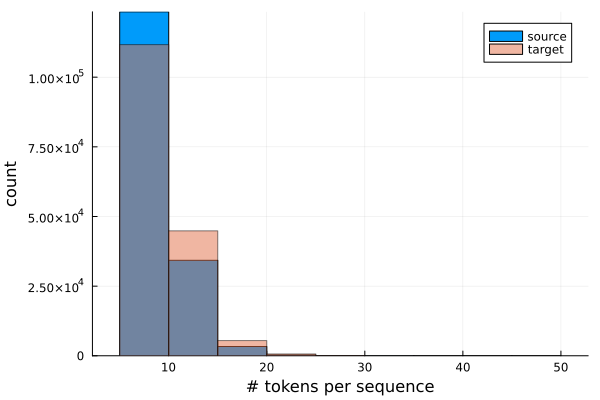

In [13]:
function show_list_len_pair_hist(labels, xlabel, ylabel, x, y)
    histogram(length.(x), label = labels[1], xlabel = xlabel, ylabel = ylabel, bins = 5:5:50)
    histogram!(length.(y), label = labels[2], bins = 5:5:50, alpha = 0.5, )
end
show_list_len_pair_hist(["source", "target"], "# tokens per sequence", "count", src, tgt)



## Loading Sequences of Fixed Length

Recall that in language modeling
each example sequence,
either a segment of one sentence
or a span over multiple sentences,
(**had a fixed length.**)
This was specified by the `num_steps`
(number of time steps or tokens) argument from :numref:`sec_language-model`.
In machine translation, each example is
a pair of source and target text sequences,
where the two text sequences may have different lengths.

For computational efficiency,
we can still process a minibatch of text sequences
at one time by *truncation* and *padding*.
Suppose that every sequence in the same minibatch
should have the same length `num_steps`.
If a text sequence has fewer than `num_steps` tokens,
we will keep appending the special "&lt;pad&gt;" token
to its end until its length reaches `num_steps`.
Otherwise, we will truncate the text sequence
by only taking its first `num_steps` tokens
and discarding the remaining.
In this way, every text sequence
will have the same length
to be loaded in minibatches of the same shape.
Furthermore, we also record length of the source sequence excluding padding tokens.
This information will be needed by some models that we will cover later.


Since the machine translation dataset
consists of pairs of languages,
we can build two vocabularies for
both the source language and
the target language separately.
With word-level tokenization,
the vocabulary size will be significantly larger
than that using character-level tokenization.
To alleviate this,
here we treat infrequent tokens
that appear less than twice
as the same unknown ("&lt;unk&gt;") token.
As we will explain later (:numref:`fig_seq2seq`),
when training with target sequences,
the decoder output (label tokens)
can be the same decoder input (target tokens),
shifted by one token;
and the special beginning-of-sequence "&lt;bos&gt;" token
will be used as the first input token
for predicting the target sequence (:numref:`fig_seq2seq_predict`).


In [15]:

function _build_array(::Type{MTFraEng},sentences, vocab, num_steps; is_tgt = false)
    pad_or_trim = (seq, t) -> length(seq) > t ?  seq[1:t] : vcat(seq, fill("<pad>", t - length(seq)))
    sentences = map(s -> pad_or_trim(s, num_steps), sentences)
    if is_tgt 
        sentences = map(s -> vcat(["<bos>"], s), sentences)
    end
    if isnothing(vocab)
        vocab = Vocab(; tokens = sentences, min_freq = 2)
    end
    array = [vocab[s] for s in sentences]
    valid_len = map(a -> sum(a .!= vocab["<pad>"]), array)
    return reduce(hcat, array), vocab, valid_len
end

function _build_arrays(::Type{MTFraEng}, raw_text, num_steps, src_vocab = nothing, tgt_vocab = nothing)
    src, tgt = _tokenize(MTFraEng, _preprocess(MTFraEng, raw_text))
    src_array, src_vocab, src_valid_len = _build_array(MTFraEng, src, src_vocab, num_steps)
    tgt_array, tgt_vocab, _ = _build_array(MTFraEng, tgt, tgt_vocab, num_steps, is_tgt = true)
    return (src_array, tgt_array[1:end-1, :], src_valid_len, tgt_array[2:end, :]),
            src_vocab, tgt_vocab
end

function MTFraEng(batchsize::Int64, num_steps::Int64=9; num_train=512, num_val=128)
    raw_text = _download(MTFraEng)
    arrays, src_vocab, tgt_vocab = _build_arrays(MTFraEng, raw_text, num_steps)
    args = (; batchsize, num_steps, num_train, num_val)
    MTFraEng(src_vocab, tgt_vocab, arrays, args)
end



MTFraEng

## Reading the Dataset

Finally, we define the `get_dataloader` method
to return the data iterator.


In [18]:
function d2lai.get_dataloader(data::MTFraEng; train = true)
    idxs = train ? (1:data.args.num_train) : (data.args.num_train+1):(data.args.num_train+data.args.num_val)
    # converts to one hot first 
    # conversion is required because unlike the pytorch implementation, this cannot be part of the inference, due to Zygote diff errors.
    src_arr = data.arrays[1][:, idxs]
    decoder_arr = data.arrays[2][:, idxs]
    labels = data.arrays[4][:, idxs]
    src_valid_len = data.arrays[3][idxs]
    # constructs the dataloader now
    Flux.DataLoader((src_arr, decoder_arr, src_valid_len, labels), shuffle = train, batchsize = data.args.batchsize)
end


Let’s read the first minibatch from the English–French dataset.



In [27]:
data = MTFraEng(3)
src, tgt, src_valid_len, label = first(d2lai.get_dataloader(data))
println("source:", src) 
println("decoder input:", tgt)
println()
println("source len excluding pad:", src_valid_len)
println("label:", label)

source:[1669 5025 5393; 5210 4503 4111; 1 80 80; 194 194 194; 195 195 195; 195 195 195; 195 195 195; 195 195 195; 195 195 195]
decoder input:[146 146 146; 928 769 8992; 19272 1756 17195; 9909 1 18004; 10674 2 33; 1 147 147; 2 148 148; 147 148 148; 148 148 148]

source len excluding pad:[4, 4, 4]
label:[928 769 8992; 19272 1756 17195; 9909 1 18004; 10674 2 33; 1 147 147; 2 148 148; 147 148 148; 148 148 148; 148 148 148]


We show a pair of source and target sequences processed by the above _build_arrays method (in the string format).



In [28]:
function build(data::MTFraEng, src_sentences, tgt_sentences)
    raw_text = join([src * "\t" * tgt for (src, tgt) in zip(src_sentences, tgt_sentences)], "\n")
    arrays, _ = _build_arrays(MTFraEng, raw_text, data.args.num_steps, data.src_vocab, data.tgt_vocab)
    arrays
end

build (generic function with 1 method)

In [29]:
src, tgt, _ = build(data, ["hi ."], ["salut ."])
println("source:", d2lai.to_tokens(data.src_vocab, vec(src)))

println("target:", d2lai.to_tokens(data.tgt_vocab, vec(tgt)))

source:["hi", ".", "<eos>", "<pad>", "<pad>", "<pad>", "<pad>", "<pad>", "<pad>"]
target:["<bos>", "salut", ".", "<eos>", "<pad>", "<pad>", "<pad>", "<pad>", "<pad>"]


## Summary

In natural language processing, *machine translation* refers to the task of automatically mapping from a sequence representing a string of text in a *source* language to a string representing a plausible translation in a *target* language. Using word-level tokenization, the vocabulary size will be significantly larger than that using character-level tokenization, but the sequence lengths will be much shorter. To mitigate the large vocabulary size, we can treat infrequent tokens as some "unknown" token. We can truncate and pad text sequences so that all of them will have the same length to be loaded in minibatches. Modern implementations often bucket sequences with similar lengths to avoid wasting excessive computation on padding. 


## Exercises

1. Try different values of the `max_examples` argument in the `_tokenize` method. How does this affect the vocabulary sizes of the source language and the target language?
1. Text in some languages such as Chinese and Japanese does not have word boundary indicators (e.g., space). Is word-level tokenization still a good idea for such cases? Why or why not?
